In [1]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [2]:
# Standard imports
import numpy as np
import pylab as plt
import torch

# Set randomness
np.random.seed(25)
torch.manual_seed(25)

# Import swyft
import swyft
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Replace with 'cpu' if no GPU available

In [3]:
def simulator(v):
    a, b = v
    x = np.linspace(-1, 1, 100)
    y = a*x + b
    return dict(y=y)

In [4]:
sim = swyft.Simulator(simulator, ["a", "b"], sim_shapes = dict(y=(100,)))

In [5]:
prior = swyft.Prior(lambda u: u*2-1, 2)
prior.save("example3.prior.pt")
prior = swyft.Prior.load("example3.prior.pt")

In [6]:
store = swyft.MemoryStore(sim)
store.add(1000, prior)
store.simulate()

Creating new store.
Store: Adding 1041 new samples to simulator store.


In [7]:
def noise(obs, v, sigma=0.05):
    y = obs['y']
    n = np.random.randn(*y.shape)*sigma
    return dict(y=y+n)

In [8]:
dataset = swyft.Dataset(1000, prior, store, simhook = noise)
dataset.save("examples3.dataset.pt")
dataset = swyft.Dataset.load("examples3.dataset.pt", store, simhook = noise)

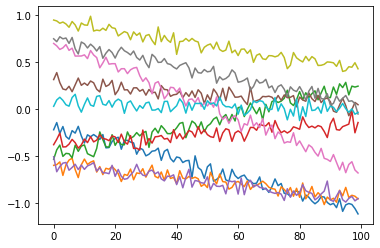

In [9]:
for i in range(10):
    plt.plot(dataset[i][0]['y'])

In [10]:
class CustomHead(swyft.Module):
    def __init__(self, sim_shapes):
        super().__init__(sim_shapes=sim_shapes)
        self.n_features = 2
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([100]))
        self.l = torch.nn.Linear(100, 2)

    def forward(self, obs):
        x=obs['y']
        x = self.onl_f(x)
        x = self.l(x)
        return x

In [11]:
post = swyft.Posteriors(dataset)

In [12]:
marginals = [0, 1]
post.add(marginals, device = DEVICE, head = CustomHead)
post.train(marginals, max_epochs = 10)

Training: lr=0.001, Epoch=10, VL=0.4929


In [13]:
post.save("examples3.post.pt")
post = swyft.Posteriors.load("examples3.post.pt").to(DEVICE)

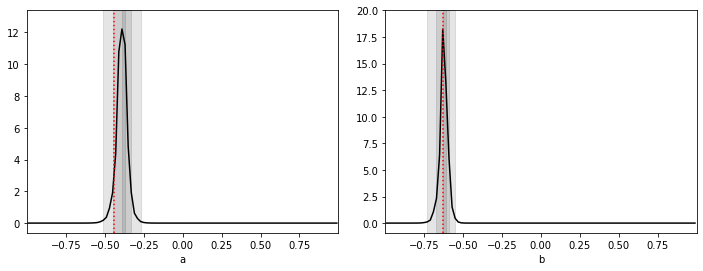

In [14]:
i = 0
obs0 = dataset[i][0]
v0 = dataset[i][2]
samples=post.sample(100000, obs0)
swyft.plot_1d(samples, [0, 1], truth = v0, figsize = (12, 4), bins = 100);